In [225]:
import gc
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea

import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

In [226]:
def dataIter(x):
    return next(iter(x))

In [227]:
# ls

In [228]:
train = pd.read_csv(r'covid_data/train.csv')
test = pd.read_csv(r'covid_data/test.csv')

In [229]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35995 entries, 0 to 35994
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              35995 non-null  int64  
 1   Province_State  15295 non-null  object 
 2   Country_Region  35995 non-null  object 
 3   Date            35995 non-null  object 
 4   ConfirmedCases  35995 non-null  float64
 5   Fatalities      35995 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 1.6+ MB


In [230]:
train.Date = pd.to_datetime(train.Date, infer_datetime_format=True)
test.Date = pd.to_datetime(test.Date,  infer_datetime_format=True)

/tmp/ipykernel_6039/319639393.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  train.Date = pd.to_datetime(train.Date, infer_datetime_format=True)
/tmp/ipykernel_6039/319639393.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  test.Date = pd.to_datetime(test.Date,  infer_datetime_format=True)


In [231]:
## uncomment to check
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35995 entries, 0 to 35994
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Id              35995 non-null  int64         
 1   Province_State  15295 non-null  object        
 2   Country_Region  35995 non-null  object        
 3   Date            35995 non-null  datetime64[ns]
 4   ConfirmedCases  35995 non-null  float64       
 5   Fatalities      35995 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 1.6+ MB


In [232]:
print(f'train \nstart date: {train.Date.min()}, end date: {train.Date.max()}') 
print(f'test \nstart date: {test.Date.min()}, end date: {test.Date.max()}') 

train 
start date: 2020-01-22 00:00:00, end date: 2020-05-15 00:00:00
test 
start date: 2020-04-02 00:00:00, end date: 2020-05-14 00:00:00


In [233]:
train.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


In [234]:
## lets set index 'Id'
train.set_index('Id', inplace=True)

In [235]:
train.head()

,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
Id,,,,,
1,NaN,Afghanistan,2020-01-22,0.0,0.0
2,NaN,Afghanistan,2020-01-23,0.0,0.0
3,NaN,Afghanistan,2020-01-24,0.0,0.0
4,NaN,Afghanistan,2020-01-25,0.0,0.0
5,NaN,Afghanistan,2020-01-26,0.0,0.0


(array([3.5136e+04, 4.1800e+02, 1.2700e+02, 8.5000e+01, 9.4000e+01,
        5.3000e+01, 5.2000e+01, 9.0000e+00, 7.0000e+00, 1.4000e+01]),
 array([     0. ,  34581.3,  69162.6, 103743.9, 138325.2, 172906.5,
        207487.8, 242069.1, 276650.4, 311231.7, 345813. ]),
 <BarContainer object of 10 artists>)

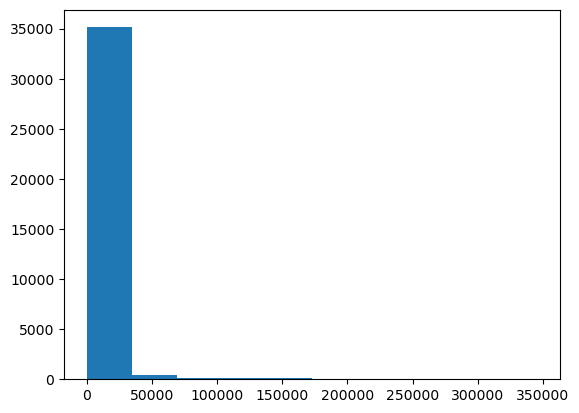

In [236]:
plt.hist(train['ConfirmedCases'])

<Axes: xlabel='ConfirmedCases', ylabel='Density'>

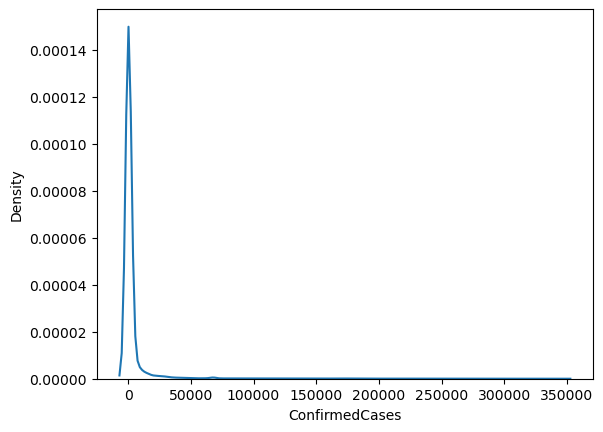

In [237]:
sea.kdeplot(data= train, x= 'ConfirmedCases')

In [238]:
# very left  skewed, lets transform data

In [239]:
# a= [10,100,1000,10000,100000,10000000]
# sea.kdeplot(np.log1p(a))

<Axes: xlabel='ConfirmedCases', ylabel='Density'>

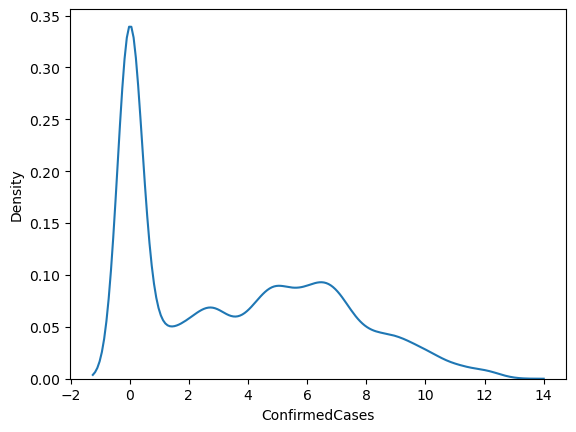

In [240]:
train.ConfirmedCases = np.log1p(train.ConfirmedCases)
sea.kdeplot(train.ConfirmedCases)

In [241]:
len(train), train.Province_State.isnull().sum(), train.Province_State.isnull().mean() 

(35995, 20700, 0.5750798722044729)

- **more then 50% of the values are missing in province state**

In [26]:
## Non Null Province_State
# train.loc[~train.Province_State.isnull(), 'Province_State']

Id
921      Australian Capital Territory
922      Australian Capital Territory
923      Australian Capital Territory
924      Australian Capital Territory
925      Australian Capital Territory
                     ...             
34956        Turks and Caicos Islands
34957        Turks and Caicos Islands
34958        Turks and Caicos Islands
34959        Turks and Caicos Islands
34960        Turks and Caicos Islands
Name: Province_State, Length: 15295, dtype: object

In [242]:
## We will combine Province_State and Country_Region and drop the unwanted columns
train['CRPS'] = train.Country_Region + '_' + train.Province_State.fillna('') 
train.drop(['Country_Region', 'Province_State', 'Fatalities'], axis=1, inplace=True)

In [243]:
train.head()

,Date,ConfirmedCases,CRPS
Id,,,
1,2020-01-22,0.0,Afghanistan_
2,2020-01-23,0.0,Afghanistan_
3,2020-01-24,0.0,Afghanistan_
4,2020-01-25,0.0,Afghanistan_
5,2020-01-26,0.0,Afghanistan_


In [244]:
import re

def make_date(df, date_field):
    "Make sure `df[date_field]` is of the right date type."
    field_dtype = df[date_field].dtype
    if isinstance(field_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        field_dtype = np.datetime64
    if not np.issubdtype(field_dtype, np.datetime64):
        df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)

def add_datepart(df, field_name, prefix=None, drop=True, time=False):
    "Helper function that adds columns relevant to a date in the column `field_name` of `df`."
    make_date(df, field_name)
    field = df[field_name]
    if prefix is None:
        prefix = re.sub('[Dd]ate$', '', field_name) 
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start',
            'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    
    week = field.dt.isocalendar().week.astype(field.dt.day.dtype) if hasattr(field.dt, 'isocalendar') else field.dt.week
    
    for n in attr: df[prefix + n] = getattr(field.dt, n.lower()) if n != 'Week' else week
    df[prefix + 'Elapsed'] = field.astype(np.int64) // 10 ** 9
    if drop: df.drop(field_name, axis=1, inplace=True)
    return df

In [245]:
train.Date = pd.to_datetime(train.Date, infer_datetime_format=True)
train = add_datepart(train, 'Date', drop=False)
train.drop(train.columns[train.nunique() == 1], axis=1, inplace=True)# droping columns like 'year' with single unique value
train.head()

/tmp/ipykernel_6039/1356800857.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  train.Date = pd.to_datetime(train.Date, infer_datetime_format=True)


,Date,ConfirmedCases,CRPS,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Elapsed
Id,,,,,,,,,,,,,
1,2020-01-22,0.0,Afghanistan_,1,4,22,2,22,False,False,False,False,1579651200
2,2020-01-23,0.0,Afghanistan_,1,4,23,3,23,False,False,False,False,1579737600
3,2020-01-24,0.0,Afghanistan_,1,4,24,4,24,False,False,False,False,1579824000
4,2020-01-25,0.0,Afghanistan_,1,4,25,5,25,False,False,False,False,1579910400
5,2020-01-26,0.0,Afghanistan_,1,4,26,6,26,False,False,False,False,1579996800


In [246]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35995 entries, 1 to 35995
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              35995 non-null  datetime64[ns]
 1   ConfirmedCases    35995 non-null  float64       
 2   CRPS              35995 non-null  object        
 3   Month             35995 non-null  int32         
 4   Week              35995 non-null  int32         
 5   Day               35995 non-null  int32         
 6   Dayofweek         35995 non-null  int32         
 7   Dayofyear         35995 non-null  int32         
 8   Is_month_end      35995 non-null  bool          
 9   Is_month_start    35995 non-null  bool          
 10  Is_quarter_end    35995 non-null  bool          
 11  Is_quarter_start  35995 non-null  bool          
 12  Elapsed           35995 non-null  int64         
dtypes: bool(4), datetime64[ns](1), float64(1), int32(5), int64(1), object(1)
memory u

In [247]:
## lets convert all the boolean value
for col in train.select_dtypes(include='bool').columns.to_list():
    train[col] = train[col].astype(int) 
## convert int32 to int64
for col in train.select_dtypes(include=np.int32).columns.to_list():
    train[col] = train[col].astype(int) 
## convert ConfirmedCases to float32
train['ConfirmedCases'] = train['ConfirmedCases'].astype(np.float32)

In [248]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35995 entries, 1 to 35995
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              35995 non-null  datetime64[ns]
 1   ConfirmedCases    35995 non-null  float32       
 2   CRPS              35995 non-null  object        
 3   Month             35995 non-null  int64         
 4   Week              35995 non-null  int64         
 5   Day               35995 non-null  int64         
 6   Dayofweek         35995 non-null  int64         
 7   Dayofyear         35995 non-null  int64         
 8   Is_month_end      35995 non-null  int64         
 9   Is_month_start    35995 non-null  int64         
 10  Is_quarter_end    35995 non-null  int64         
 11  Is_quarter_start  35995 non-null  int64         
 12  Elapsed           35995 non-null  int64         
dtypes: datetime64[ns](1), float32(1), int64(10), object(1)
memory usage: 3.7+ MB


In [249]:
# lets separate out categorical and continuous columns
features = [c for c in train.columns if c not in ['Date','ConfirmedCases']]
cat_feat = ['CRPS', 'Month', 'Dayofweek']
cont_feat = [c for c in features if c not in cat_feat]
cat_feat, cont_feat

(['CRPS', 'Month', 'Dayofweek'],
 ['Week',
  'Day',
  'Dayofyear',
  'Is_month_end',
  'Is_month_start',
  'Is_quarter_end',
  'Is_quarter_start',
  'Elapsed'])

In [250]:
## lets encode cat col
from sklearn.preprocessing import LabelEncoder

encoders = {}
for f in cat_feat:
    le = LabelEncoder()
    train[f] = le.fit_transform(train[f].values)
    encoders[f] = le

In [251]:
encoders

{'CRPS': LabelEncoder(), 'Month': LabelEncoder(), 'Dayofweek': LabelEncoder()}

In [252]:
train['isValid'] = 0
train.loc[train.Date >= test.Date.min(), 'isValid'] = 1

In [253]:
train.isValid.value_counts()

isValid
0    22223
1    13772
Name: count, dtype: int64

In [254]:
## data split
train, test = train[train.isValid == 0], train[train.isValid == 1]

In [255]:
train.shape, test.shape

((22223, 14), (13772, 14))

In [256]:
### we are good till now, lets Work on Datatset and Dataloader class

# Dataset and DataLoaders


In [258]:
class CovidDatatset(Dataset):
    def __init__(self,train,cat_feats, target='ConfirmedCases'):
        self.y = train[target]
        self.x_cat = train[cat_feats]
        self.x_cont = train.drop(cat_feats + [target], axis=1)
    
    def __getitem__(self, idx):
        return  torch.tensor(self.x_cat.iloc[idx]), torch.tensor(self.x_cont.iloc[idx]), torch.tensor(self.y.iloc[idx]) 
    
    def __len__(self):
        return len(self.y)

In [259]:
bs =1024

In [260]:
train_ds = CovidDatatset(train[features+['ConfirmedCases']], cat_feat)
valid_ds = CovidDatatset(test[features+['ConfirmedCases']], cat_feat)

train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False)

In [ ]:
valid_dl

# Building Model

In [261]:
# we will use embeddings to handle the categorical columns

In [262]:
# to select we are using the :rule of thumb to pick embeddings 'source:Fastai'
def emb_sz(n_cat):
    return min(600, round(1.6 * n_cat**0.56))

def get_emb_sz(d):
    emb_szs = [(c, int(emb_sz(c))) for c in d]
    return emb_szs

In [263]:
uninque= [train[c].nunique() for c in cat_feat]# uninque, cat_feat
emb_sz = get_emb_sz(uninque)

In [264]:
emb_sz

[(313, 40), (4, 3), (7, 5)]

In [265]:
class CovidNet(nn.Module):
    def __init__(self, emb_sz, n_cont):
        super().__init__()
        self.embs = nn.ModuleList([nn.Embedding(c,n) for c,n in emb_sz])
        n_cat = sum([n for _,n in emb_sz])#48
        self.classifier = nn.Sequential(
            nn.Linear((n_cat+n_cont), 128),
            nn.ReLU(),
            nn.Linear(128,1)
        )
        self.emb_dp = nn.Dropout(0.5)
    
    def forward(self, x_cat, x_cont):
        x_embs = [emb(x_cat[:, i]) for i, emb in enumerate(self.embs)] #embedding matrix of all cat var.
        x_embs = torch.cat(x_embs, 1)
        
        x = torch.cat((x_cont.type(torch.FloatTensor), x_embs), 1)
        x =self.classifier(x)
        return x.squeeze()

In [266]:
# The main difference between nn.Sequential is that nn.ModuleList have not a forward() 
# method so the inner layers are not connected. That is why we have concated the embeddings

In [267]:
model = CovidNet(emb_sz, len(cont_feat))
model

CovidNet(
  (embs): ModuleList(
    (0): Embedding(313, 40)
    (1): Embedding(4, 3)
    (2): Embedding(7, 5)
  )
  (classifier): Sequential(
    (0): Linear(in_features=56, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
  (emb_dp): Dropout(p=0.5, inplace=False)
)

In [268]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [273]:
def train_model(epochs=3):
    for i in range(epochs):
        ## Training
        train_loss = 0.0
        model.train()
        for X1s, X2s, ys in train_dl:
            optimizer.zero_grad()
            preds = model(X1s, X2s)
#             print(preds.dtype, ys.dtype)
            loss = loss_fn(preds, ys)
#             print(loss.dtype)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_dl)

#         ## Testing
#         test_loss = 0.0
#         model.eval()
#         with torch.no_grad():
#             for X1s, X2s, ys in valid_dl:
#                 preds = model(X1s, X2s)
#                 loss = loss_fn(preds, ys)
#                 test_loss += loss.item()

#             test_loss /= len(valid_dl)
        
        print(f'| Epoch: {(i+1):02} | Train Loss: {train_loss:.3f} ')
# | Val. Loss:  {test_loss:.3f}

In [275]:
train_model(10)

| Epoch: 01 | Train Loss: 8.099 
| Epoch: 02 | Train Loss: 8.090 
| Epoch: 03 | Train Loss: 8.107 
| Epoch: 04 | Train Loss: 8.090 
| Epoch: 05 | Train Loss: 8.093 
| Epoch: 06 | Train Loss: 8.096 
| Epoch: 07 | Train Loss: 8.101 
| Epoch: 08 | Train Loss: 8.098 
| Epoch: 09 | Train Loss: 8.109 
| Epoch: 10 | Train Loss: 8.086 
